In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average")



# 9.4.1 SARIMAX 모델에 모든 외생 변수를 사용하여 실질 GDP 예측

## 1. SARIMAX 모델에 모든 외생 변수를 사용한다.

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


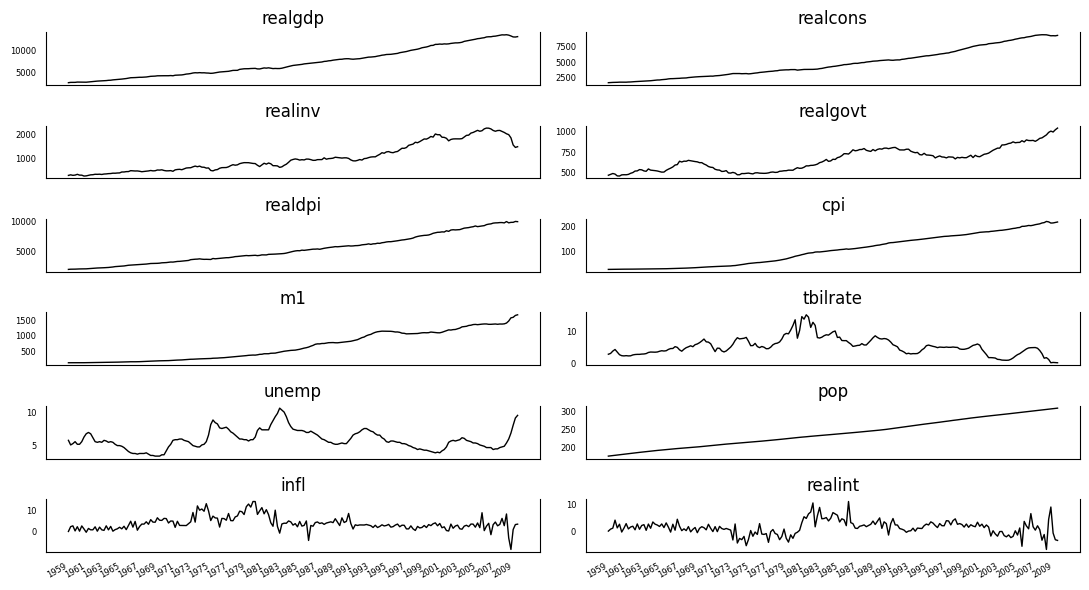

In [3]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(11, 6))

for i, ax in enumerate(axes.flatten()):
  data = macro_econ_data[macro_econ_data.columns[i+2]]

  ax.plot(data, color = 'black', linewidth=1)
  ax.set_title(macro_econ_data.columns[i+2])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
target = macro_econ_data['realgdp']
exog = macro_econ_data.drop(columns=['year','realgdp','quarter'])

exog

,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...
198,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [5]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647084
p-value: 0.9982455372335032


In [6]:
target_diff = target.diff()

In [7]:
ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08


In [8]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list],
                    order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

  results = []

  for order in tqdm(order_list):
    try:
      model = SARIMAX(
          endog,
          exog,
          order=(order[0], d, order[1]),
          seasonal_order=(order[2], D, order[3], s),
          simple_differencing=False).fit(disp=False)
    except:
      continue

    aic = model.aic
    results.append([order, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q,P,Q)', 'AIC']

  result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
  return result_df

In [9]:
p = range(0, 4, 1)
d = 1
q = range(0,4,1)
P = range(0,4,1)
D = 0
Q = range(0,4,1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [10]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df
# SARIMAX(2,1,2)(1,0,0)4

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 1, 0)",1757.143846
1,"(3, 3, 0, 0)",1757.886220
2,"(2, 2, 0, 2)",1758.302435
3,"(2, 2, 0, 0)",1759.094721
4,"(2, 2, 2, 0)",1759.468191
...,...,...
251,"(3, 2, 2, 1)",1776.806726
252,"(3, 2, 1, 3)",1776.867116
253,"(3, 2, 1, 1)",1776.944881
254,"(3, 2, 1, 2)",1778.132035


## 2. 잔차 분석

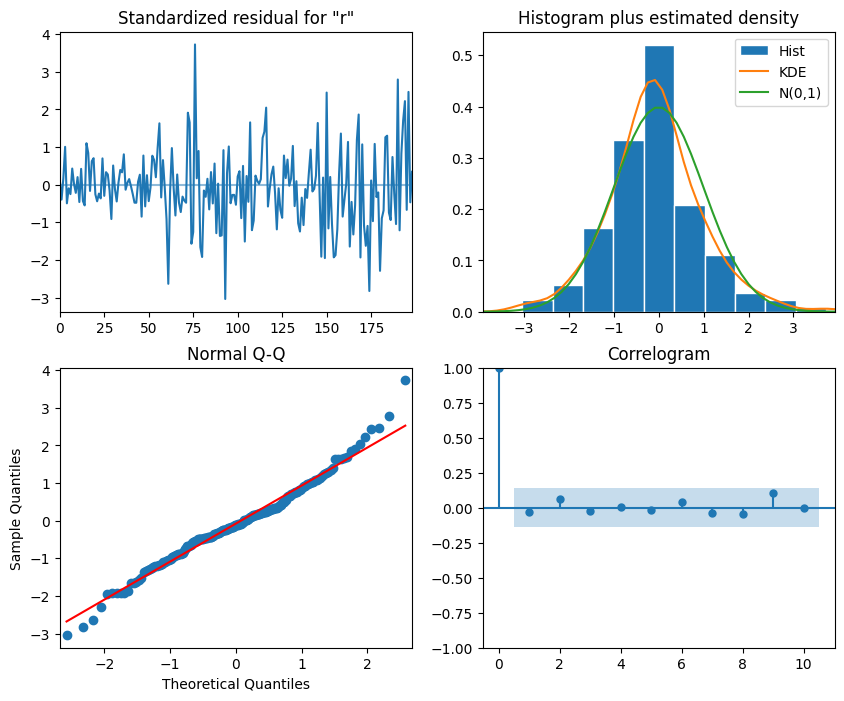

In [11]:
best_model = SARIMAX(target_train, exog_train, order=(2,1,2), seasonal_order=(1,0,0,4),
                     simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

# Q-Q 도식
best_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [12]:
# 융-박스 테스트
residuals = best_model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue["lb_pvalue"].to_numpy())

[0.90267757 0.96997269 0.99445636 0.99476456 0.9988605  0.99978111
 0.99996209 0.99998284 0.99999627 0.99999935]


## 3. 데이터 집합의 마지막 7개 시간 단계에 대한 에측 생성

In [13]:
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list],
                     train_len: int, horizon: int, window: int, method: str) -> list:

  total_len = train_len + horizon

  # 마지막 값
  if method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = endog[:i].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  # SARIMAX
  elif method == 'SARIMAX':
    pred_SARIMAX = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(endog[:i], exog[:i], order=(2, 1, 2),
                      seasonal_order=(1,0,0,4), simple_differencing=False)
      res = model.fit(disp=False)
      predictions = res.get_prediction(exog=exog)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_SARIMAX.extend(oos_pred)

    return pred_SARIMAX

In [14]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['last_value'] = pred_last_value
pred_df['SARIMAX'] = pred_SARIMAX

pred_df

,actual,last_value,SARIMAX
196,13366.865,13391.249,13345.340427
197,13415.266,13366.865,13374.938457
198,13324.600,13415.266,13368.605003
199,13141.920,13324.600,13331.790359
200,12925.410,13141.920,13135.693641
201,12901.504,12925.410,12887.910919
202,12990.341,12901.504,12868.797428


## 4. MAPE 측정

In [15]:
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
mape_last = mape(pred_df.actual, pred_df.last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.SARIMAX)

print(mape_last, mape_SARIMAX)
# 외생변수 5개만 사용한 경우의 MAPE 0.7

0.736849498653785 0.7006526587374518


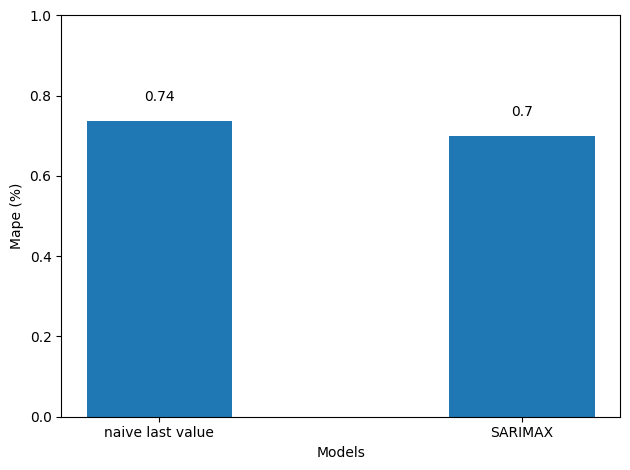

In [17]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width = 0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mape (%)')
ax.set_ylim(0,1)

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()